In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
from bs4 import BeautifulSoup as bs
import requests
import json
import re
from datetime import datetime

## Load the webpage for Interstellar

In [2]:
# Start off by loading in a single movie webpage

r = requests.get("https://en.wikipedia.org/wiki/Interstellar_(film)")

soup = bs(r.content)
info_box = soup.find(class_="infobox vevent")
info_rows = info_box.find_all("tr")

In [3]:
for row in info_rows:
    print(row.prettify())

# This is the info box from wikipedia for this movie

<tr>
 <th class="infobox-above summary" colspan="2" style="font-size: 125%; font-style: italic;">
  Interstellar
 </th>
</tr>

<tr>
 <td class="infobox-image" colspan="2">
  <a class="image" href="/wiki/File:Interstellar_film_poster.jpg">
   <img alt="Interstellar film poster.jpg" class="thumbborder" data-file-height="326" data-file-width="220" decoding="async" height="326" src="//upload.wikimedia.org/wikipedia/en/b/bc/Interstellar_film_poster.jpg" width="220"/>
  </a>
  <div class="infobox-caption">
   Theatrical release poster
  </div>
 </td>
</tr>

<tr>
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">
  Directed by
 </th>
 <td class="infobox-data">
  <a href="/wiki/Christopher_Nolan" title="Christopher Nolan">
   Christopher Nolan
  </a>
 </td>
</tr>

<tr>
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">
  Written by
 </th>
 <td class="infobox-data">
  <div class="plainlist">
   <ul>
    <li>
     

In [4]:
def list_vals(rows):
    if rows.find("li"):
        return [li.get_text(" ", strip=True).replace("\xa0", " ") for li in rows.find_all("li")]
    else:
        return rows.get_text(" ", strip=True).replace("\xa0", " ")
        
movie_info = {}
for index, row in enumerate(info_rows):
    if index == 0:
        movie_info["title"] = row.find("th").get_text(" ", strip=True)
    elif index == 1:
        continue
    else:
        content_key = row.find("th").get_text(" ", strip=True)
        content_val = list_vals(row.find("td"))
        movie_info[content_key] = content_val 

movie_info

{'title': 'Interstellar',
 'Directed by': 'Christopher Nolan',
 'Written by': ['Jonathan Nolan', 'Christopher Nolan'],
 'Produced by': ['Emma Thomas', 'Christopher Nolan', 'Lynda Obst'],
 'Starring': ['Matthew McConaughey',
  'Anne Hathaway',
  'Jessica Chastain',
  'Bill Irwin',
  'Ellen Burstyn',
  'Michael Caine'],
 'Cinematography': 'Hoyte van Hoytema',
 'Edited by': 'Lee Smith',
 'Music by': 'Hans Zimmer',
 'Production companies': ['Paramount Pictures',
  'Warner Bros. Pictures',
  'Legendary Pictures',
  'Syncopy',
  'Lynda Obst Productions'],
 'Distributed by': ['Paramount Pictures (North America)',
  'Warner Bros. Pictures (International)'],
 'Release date': ['October 26, 2014 ( 2014-10-26 ) ( TCL Chinese Theatre )',
  'November 5, 2014 ( 2014-11-05 ) (United States)',
  'November 7, 2014 ( 2014-11-07 ) (United Kingdom)'],
 'Running time': '169 minutes [1]',
 'Countries': ['United Kingdom [2]', 'United States [2]'],
 'Language': 'English',
 'Budget': '$165 million [3]',
 'Box o

# Get info for all Christopher Nolan movies

In [5]:
# These functions help with scraping the infobox data into a dictionary

def list_vals(rows):
    if rows.find("li"):
        return [li.get_text(" ", strip=True).replace("\xa0", " ") for li in rows.find_all("li")]
    else:
        return rows.get_text(" ", strip=True).replace("\xa0", " ")

def remove_sup(soup):
    for tag in soup.find_all(["sup","span"]):
        tag.decompose()

def get_movie_info(url):
    r = requests.get(url)
    soup = bs(r.content)
    
    info_box = soup.find(class_="infobox vevent")
    info_rows = info_box.find_all("tr")

    remove_sup(info_box)
    movie_info = {}
    for index, row in enumerate(info_rows):
        if index == 0:
            movie_info["title"] = row.find("th").get_text(" ", strip=True)
        elif index == 1:
            continue
        else:
            content_key = row.find("th").get_text(" ", strip=True)
            content_val = list_vals(row.find("td"))
            movie_info[content_key] = content_val 
    return movie_info

In [6]:
# Get the wikipedia links for each of the movies

r = requests.get("https://en.wikipedia.org/wiki/Christopher_Nolan")
soup = bs(r.content)
movies = soup.find(class_="wikitable")
info_rows = movies.find_all("i")
info_rows

[<i><a href="/wiki/Following" title="Following">Following</a></i>,
 <i><a href="/wiki/Memento_(film)" title="Memento (film)">Memento</a></i>,
 <i><a href="/wiki/Insomnia_(2002_film)" title="Insomnia (2002 film)">Insomnia</a></i>,
 <i><a href="/wiki/Batman_Begins" title="Batman Begins">Batman Begins</a></i>,
 <i><a href="/wiki/The_Prestige_(film)" title="The Prestige (film)">The Prestige</a></i>,
 <i><a href="/wiki/The_Dark_Knight_(film)" title="The Dark Knight (film)">The Dark Knight</a></i>,
 <i><a href="/wiki/Inception" title="Inception">Inception</a></i>,
 <i><a href="/wiki/The_Dark_Knight_Rises" title="The Dark Knight Rises">The Dark Knight Rises</a></i>,
 <i><a href="/wiki/Interstellar_(film)" title="Interstellar (film)">Interstellar</a></i>,
 <i><a href="/wiki/Dunkirk_(2017_film)" title="Dunkirk (2017 film)">Dunkirk</a></i>,
 <i><a href="/wiki/Tenet_(film)" title="Tenet (film)">Tenet</a></i>,
 <i><a class="mw-redirect" href="/wiki/Oppenheimer_(film)" title="Oppenheimer (film)">Op

In [7]:
ROOT = "https://en.wikipedia.org"
all_movies = []
for movie in info_rows:
    try:
        url = movie.a["href"]
        full_link = ROOT + url
        all_movies.append(get_movie_info(full_link))
        
    except Exception as e:
        print(movie.a["title"])
        print(e)

Oppenheimer (film)
'NoneType' object has no attribute 'find_all'


In [8]:
all_movies

[{'title': 'Following',
  'Directed by': 'Christopher Nolan',
  'Written by': 'Christopher Nolan',
  'Produced by': ['Christopher Nolan', 'Jeremy Theobald', 'Emma Thomas'],
  'Starring': ['Jeremy Theobald', 'Alex Haw', 'Lucy Russell', 'John Nolan'],
  'Cinematography': 'Christopher Nolan',
  'Edited by': ['Gareth Heal', 'Christopher Nolan'],
  'Music by': 'David Julyan',
  'Production companies': 'Next Wave Films Syncopy',
  'Distributed by': 'Momentum Pictures',
  'Release date': ['12 September 1998 ( Toronto )',
   '5 November 1999 (United Kingdom)'],
  'Running time': '70 minutes',
  'Country': 'United Kingdom',
  'Language': 'English',
  'Budget': '$6,000',
  'Box office': '$48,482'},
 {'title': 'Memento',
  'Directed by': 'Christopher Nolan',
  'Screenplay by': 'Christopher Nolan',
  'Based on': '" Memento Mori " by Jonathan Nolan',
  'Produced by': ['Suzanne Todd', 'Jennifer Todd'],
  'Starring': ['Guy Pearce', 'Carrie-Anne Moss', 'Joe Pantoliano'],
  'Cinematography': 'Wally Pfi

## Save data as a json file

In [9]:
def save(title,data):
    with open(title, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [10]:
#save("Christopher_Nolan_Movies.json", all_movies)

## Clean data

In [11]:
data = pd.read_json("Desktop/datasets/Christopher_Nolan_Movies.json")

In [12]:
# Convert running time column to integer to ease data analysis

data["Running time"] = data["Running time"].str[0:3]
data["Running time"].str.strip(' ').astype('int')

0      70
1     113
2     118
3     140
4     130
5     152
6     148
7     165
8     169
9     106
10    150
Name: Running time, dtype: int32

In [13]:
# These functions help with handling the budget column
# It is converted to just floats

amounts = r"million|billion|thousand"
number = r"\d+(,\d{3})*\.*\d*"

word_r = rf"\${number}(-|\sto\s|–)?({number})?\s({amounts})"
value_r = rf"${number}"
value_r1 = r"\$+\d+(,\d{3})"

def amount_to_val(amount):
    amount_vals = {"million": 1000000, "billion": 1000000000, "thousand": 1000}
    return amount_vals[amount]

def word_syntax(string):
    value_string = re.search(number, string).group()
    value = float(value_string.replace(",", ""))
    word = re.search(amounts, string, flags=re.IGNORECASE).group().lower()
    word_val = amount_to_val(word)
    return word_val*value

def value_syntax(string):
    value_string = re.search(number, string).group()
    value = float(value_string.replace(",", ""))
    return value

def convert_money(money):
    if isinstance(money,list):
        money = money[1]
    word = re.search(word_r, money, flags=re.IGNORECASE)
    val = re.search(value_r, money)
    val1 = re.search(value_r1, money)
    
    if word:
        return "{:.2f}".format(word_syntax(word.group()))
    elif val:
        return "{:.2f}".format(value_syntax(word.group()))
    elif val1:
        return "{:.2f}".format(value_syntax(val1.group()))

In [14]:
# loops to change box office and budget columns to just floats
# Rename to make them clearer

for i in range(0,11):
    data.iloc[i]["Budget"] = float(convert_money(data.iloc[i]["Budget"]))
for i in range(0,11):
    data.iloc[i]["Box office"] = float(convert_money(data.iloc[i]["Box office"]))

In [15]:
# Convert dates to datetime objects

def clean_dates(date):
    return date.split("(")[0].strip()

def convert_dates(date):
    if isinstance(date, list):
        date = date[0]
    cleaned_date = clean_dates(date)
    if cleaned_date[0].isnumeric():
        final_date = datetime.strptime(cleaned_date,"%d %B %Y")
    else:
        final_date = datetime.strptime(cleaned_date,"%B %d, %Y")
    return final_date

In [16]:
# Apply datetime objects to the release date column

for i in range(0,11):
    data.iloc[i]["Release date"] = convert_dates(data.iloc[i]["Release date"])

In [17]:
# Many of the values are still in a list
# Taking them out might make it more presentable and look finished

def list_out(list_in):
    if isinstance(list_in, list):
        items = ""
        for i in range(len(list_in)):
            if i == len(list_in)-1:
                items+=(list_in[i])
            else:
                items+=(list_in[i]+", ")
        return items
    else:
        return list_in

for col in data.columns:
    for i in range(0,11):
        data.iloc[i][col] = list_out(data.iloc[i][col])

## Attach Rotten tomatoes scores to the movies

In [18]:
# Scrape rotten tomatoes website

r = requests.get("https://www.rottentomatoes.com/celebrity/christopher_nolan")
soup = bs(r.content)
info_table = soup.find(class_="celebrity-filmography__tbody")
info_rows = info_table.find_all("tr")
info_rows

[<tr data-audiencescore="94" data-boxoffice="" data-qa="celebrity-filmography-movies-trow" data-title="Zack Snyder's Justice League" data-tomatometer="71" data-year="2021">
 <td class="celebrity-filmography__score-content">
 <span class="label" data-tomatometer="71">
 <span class="icon icon--tiny icon__fresh" title="fresh"></span>
 <span class="icon__tomatometer-score" data-qa="tomatometer">71%</span>
 </span>
 </td>
 <td class="celebrity-filmography__score-content">
 <span class="label" data-audiencescore="94">
 <span class="icon icon--tiny icon__upright" title="upright"></span>
 <span class="icon__tomatometer-score" data-qa="audience-score">94%</span>
 </span>
 </td>
 <td class="celebrity-filmography__title">
 <a href="/m/zack_snyders_justice_league">Zack Snyder's Justice League</a>
 </td>
 <td class="celebrity-filmography__credits">
                         Executive Producer
                     </td>
 <td class="celebrity-filmography__box-office" data-qa="celebrity-filmography-mov

In [19]:
# Get the rotten tomato score and the audience score for movies in our dataset

movie_ratings = {}
for i in range(len(info_rows)):
    if info_rows[i]["data-title"] in [movie for movie in data["title"]]:
        movie = info_rows[i]["data-title"]
        rt_score = info_rows[i]["data-tomatometer"]
        a_score = info_rows[i]["data-audiencescore"]
        movie_ratings[movie] = [rt_score,a_score]

movie_ratings

{'Tenet': ['69', '76'],
 'Dunkirk': ['92', '81'],
 'Interstellar': ['72', '86'],
 'The Dark Knight Rises': ['87', '90'],
 'Inception': ['87', '91'],
 'The Dark Knight': ['94', '94'],
 'The Prestige': ['76', '92'],
 'Batman Begins': ['84', '94'],
 'Insomnia': ['92', '77'],
 'Memento': ['93', '94'],
 'Following': ['81', '85']}

In [20]:
# Create rotten tomato score column and audience score column

data["Rotten tomato score"] = 0       
data["Audience score"] = 0             
for movie in movie_ratings:
    data.at[data["title"].tolist().index(movie), "Rotten tomato score"] = movie_ratings[movie][0]
    data.at[data["title"].tolist().index(movie), "Audience score"] = movie_ratings[movie][1]

## Save the data into a csv file

In [21]:
#data.to_csv("Christopher Nolan Movies final")

## The final dataset is ready for analysis!

In [22]:
data

,title,Directed by,Written by,Produced by,Starring,Cinematography,Edited by,Music by,Production companies,Distributed by,...,Country,Language,Budget,Box office,Screenplay by,Based on,Story by,Countries,Rotten tomato score,Audience score
0,Following,Christopher Nolan,Christopher Nolan,"Christopher Nolan, Jeremy Theobald, Emma Thomas","Jeremy Theobald, Alex Haw, Lucy Russell, John ...",Christopher Nolan,"Gareth Heal, Christopher Nolan",David Julyan,Next Wave Films Syncopy,Momentum Pictures,...,United Kingdom,English,6000.0,48482.0,NaN,NaN,NaN,NaN,81,85
1,Memento,Christopher Nolan,NaN,"Suzanne Todd, Jennifer Todd","Guy Pearce, Carrie-Anne Moss, Joe Pantoliano",Wally Pfister,Dody Dorn,David Julyan,"Summit Entertainment, Team Todd",Newmarket,...,United States,English,9000000.0,40000000.0,Christopher Nolan,""" Memento Mori "" by Jonathan Nolan",NaN,NaN,93,94
2,Insomnia,Christopher Nolan,NaN,"Paul Junger Witt, Tony Thomas, Edward L. McDon...","Al Pacino, Robin Williams, Hilary Swank, Maura...",Wally Pfister,Dody Dorn,David Julyan,"Warner Bros. Pictures, Summit Entertainment, A...",Warner Bros. Pictures (United States and Germa...,...,United States,English,46000000.0,113800000.0,Hillary Seitz,"Nikolaj Frobenius, Erik Skjoldbjærg",NaN,NaN,92,77
3,Batman Begins,Christopher Nolan,NaN,"Charles Roven, Emma Thomas, Larry Franco","Christian Bale, Michael Caine, Liam Neeson, Ka...",Wally Pfister,Lee Smith,"Hans Zimmer, James Newton Howard","Warner Bros. Pictures, DC Comics, Legendary Pi...",Warner Bros. Pictures,...,NaN,English,150000000.0,373600000.0,"Christopher Nolan, David S. Goyer",Characters appearing in comic books published ...,David S. Goyer,"United States, United Kingdom",84,94
4,The Prestige,Christopher Nolan,NaN,"Emma Thomas, Aaron Ryder, Christopher Nolan","Hugh Jackman, Christian Bale, Michael Caine, S...",Wally Pfister,Lee Smith,David Julyan,"Touchstone Pictures, Warner Bros. Pictures, Ne...",Buena Vista Pictures Distribution (North Ameri...,...,NaN,English,40000000.0,109700000.0,"Jonathan Nolan, Christopher Nolan",The Prestige by Christopher Priest,NaN,"United Kingdom, United States",76,92
5,The Dark Knight,Christopher Nolan,NaN,"Emma Thomas, Charles Roven, Christopher Nolan","Christian Bale, Michael Caine, Heath Ledger, G...",Wally Pfister,Lee Smith,"Hans Zimmer, James Newton Howard","Warner Bros. Pictures, Legendary Pictures, DC ...",Warner Bros. Pictures,...,NaN,English,185000000.0,1005000000.0,"Jonathan Nolan, Christopher Nolan",Characters appearing in comic books published ...,"Christopher Nolan, David S. Goyer","United States, United Kingdom",94,94
6,Inception,Christopher Nolan,Christopher Nolan,"Emma Thomas, Christopher Nolan","Leonardo DiCaprio, Ken Watanabe, Joseph Gordon...",Wally Pfister,Lee Smith,Hans Zimmer,"Legendary Pictures, Syncopy",Warner Bros. Pictures,...,NaN,English,160000000.0,836800000.0,NaN,NaN,NaN,"United States, United Kingdom",87,91
7,The Dark Knight Rises,Christopher Nolan,NaN,"Emma Thomas, Christopher Nolan, Charles Roven","Christian Bale, Michael Caine, Gary Oldman, An...",Wally Pfister,Lee Smith,Hans Zimmer,"Warner Bros. Pictures, Legendary Pictures, DC ...",Warner Bros. Pictures,...,NaN,English,230000000.0,1081000000.0,"Jonathan Nolan, Christopher Nolan",Characters appearing in comic books published ...,"Christopher Nolan, David S. Goyer","United States, United Kingdom",87,90
8,Interstellar,Christopher Nolan,"Jonathan Nolan, Christopher Nolan","Emma Thomas, Christopher Nolan, Lynda Obst","Matthew McConaughey, Anne Hathaway, Jessica Ch...",Hoyte van Hoytema,Lee Smith,Hans Zimmer,"Paramount Pictures, Warner Bros. Pictures, Leg...","Paramount Pictures (North America), Warner Bro...",...,NaN,English,165000000.0,701800000.0,NaN,NaN,NaN,"United Kingdom, United States",72,86
9,Dunkirk,Christopher Nolan,Christopher Nolan,"Emma Thomas, Christopher Nolan","Fionn Whitehead, Tom Glynn-Carney, Jack Lowden...",Hoyte van Hoytema,Lee Smith,Hans Zimmer,"Warner Bros. Pictures, Syncopy Inc., RatPac-Du...",Warner B

### Budget vs. Box office for all movies
#### How well did each movie perform?

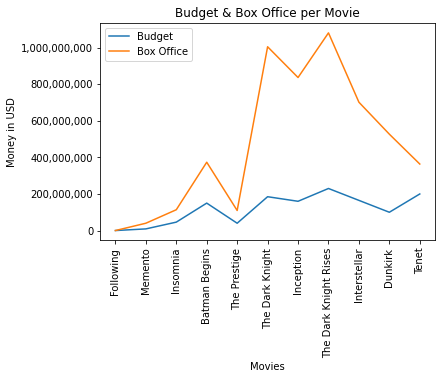

In [23]:
fig, ax = plt.subplots()

ax.plot(data.title, data["Budget"], label="Budget")
ax.plot(data.title, data["Box office"], label="Box Office")
plt.xticks(data.title, rotation=90)
plt.title("Budget & Box Office per Movie")
plt.xlabel("Movies")
plt.ylabel("Money in USD")
plt.legend(loc="upper left")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

# This graph clearly shows how well each of his movies performed in the Box Office
# The movies are also arranged in chronological order, thus the line plots show the change over time
# Some movies, like 'The Dark Knight Rises' were big hits
# whereas movies like the 'Following' barely made any profits

## What is the correlation b/w movie ratings and box office?

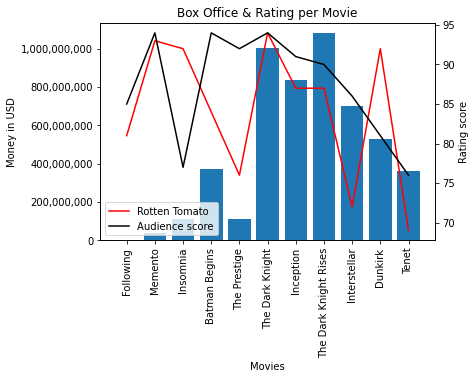

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

warnings.filterwarnings("ignore")
ax1.bar(data.title, data["Box office"])
ax2.plot(data.title, data["Rotten tomato score"], '-r', label='Rotten Tomato')
ax2.plot(data.title, data["Audience score"], '-k', label='Audience score')
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_xticklabels(data.title, rotation=90)
ax1.set_ylabel("Money in USD")
ax2.set_ylabel("Rating score")
plt.title("Box Office & Rating per Movie")
ax1.set_xlabel("Movies")
plt.legend()
plt.show()

# There are several key insights to be drawn from this figure
# Apart from a few outliers like 'Memento' and 'The Prestige', Box office generally
# goes down as audience score goes down.
# However, it is quite surprising that audience score and rotten tomato scores
# are not as strongly correlated